# Cell Type Prediction

The goal of cell type prediction is to assign a label to each cell. While methods such as clustering are frequently used in single cell transcriptomics data, these methods do not necessarily translate well to highly multiplexed fluorescence images. Instead, this notebook follows a two-step approach. In the first step, major cell types (such as B cells, T cells, macrophages, etc.) are predicted by using a set of mutually exclusive markers. These initial labels are predicted with methods such as `argmax` or `astir` and build the foundation for step two, in which we will look at functional markers. Here, we use a binarization-like approach. This means that for our functional markers, each cell gets either a value of 1 (if the cell expresses that marker) or 0 (if the cell does not express that marker). While this is a simplification of the underlying biology, this abstraction can be useful to counteract the often poor signal-to-noise ratio inherent in the data.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spatialproteomics as sp
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.signal import medfilt2d

In [3]:
ds = xr.load_dataset('../../data/BNHL_166_4_I2_LK_2.zarr', engine='zarr')

## Image Processing
Before predicting cell types, it is typically helpful to perform some preprocessing on the images. Here, we simply perform some custom thresholding on the markers to clean up the images and boost the signal-to-noise ratio.

In [4]:
# preprocessing: thresholding by percentiles and applying a median filter
channels = ['PAX5', 'CD3', 'CD11b', 'CD11c', 'CD15', 'CD68', 'Podoplanin', 'CD31', 'CD34', 'CD90', 'CD56', 'CD4', 'CD8', 'Ki-67', 'CD45RA', 'CD45RO']
quantiles = [0.8, 0.5, 0.8, 0.8, 0.8, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8, 0.95, 0.95, 0.95, 0.95, 0.95]
colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#ffd8b1', '#f58231', '#911eb4', '#fffac8', '#469990', '#fabed4', '#9A6324']

channels_celltypes = channels[:-5]

# processing and recomputing quantification
ds_processed = ds.pp[channels].pp.threshold(quantiles).pp.add_quantification().pp.transform_expression_matrix(method='arcsinh')

Text(0.5, 1.0, 'Processed')

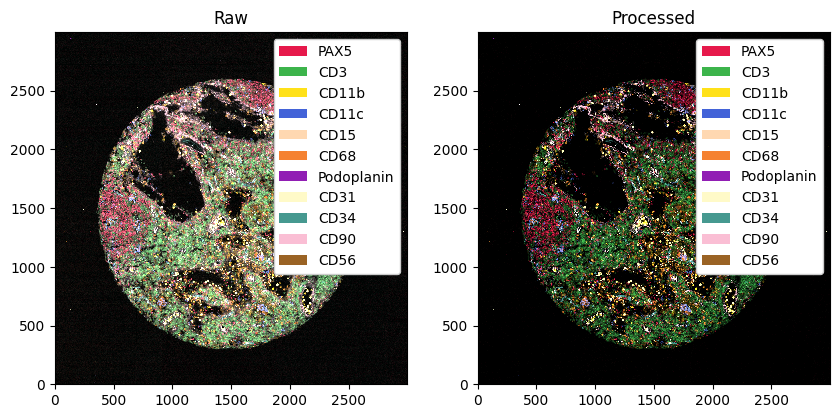

In [5]:
# plotting the ds and ds processed next to one another

# visualizing the raw vs the processed image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = ds.pp[channels_celltypes].pl.colorize(colors).pl.show(ax=ax[0])
_ = ds_processed.pp[channels_celltypes].pl.colorize(colors).pl.show(ax=ax[1])

ax[0].set_title("Raw")
ax[1].set_title("Processed")

## Cell Type Prediction with Argmax

Given the thresholded image, the simplest way to derive cell type labels is to define associations between cell types and markers, and then assign the cell type whose marker is most highly expressed (i. e. taking the argmax). This technique, also termed `argmax`, is demonstrated below.

In [6]:
ct_marker_dict = {'B': 'PAX5', 'T': 'CD3', 'Myeloid': 'CD11b', 'Dendritic': 'CD11c', 'Granulo': 'CD15', 'Macro': 'CD68', 'Stroma PDPN': 'Podoplanin', 'Stroma CD31': 'CD31', 'Stroma CD34': 'CD34', 'Stroma CD90': 'CD90', 'NK': 'CD56'}

In [7]:
# predicting the cell type using the argmay
ds_with_ct_predictions = ds_processed.la.predict_cell_types_argmax(ct_marker_dict, key='_intensity', overwrite_existing_labels=True)

# adding colors to match the markers

ds_with_ct_predictions = ds_with_ct_predictions.la.set_label_colors(list(ct_marker_dict.keys()), colors)

Removing labels from observations. If you want to keep the labels in the obs layer, set drop_obs=False.
Label Stroma PDPN not found in the data object. Skipping.


Text(0.5, 1.0, 'Cell Type Predictions')

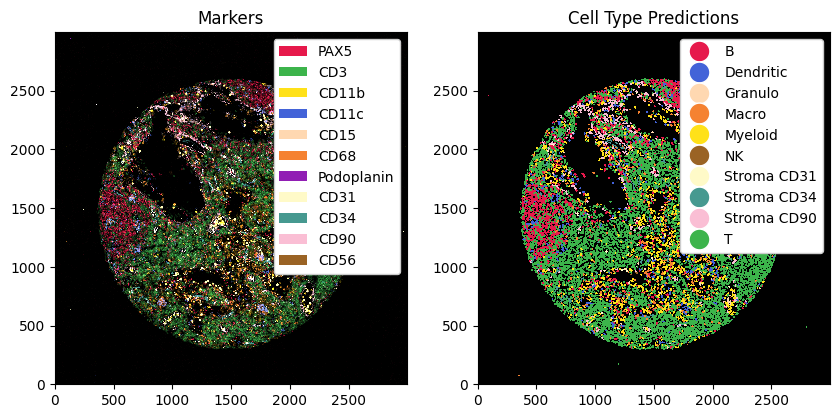

In [8]:
# plotting the ct predictions next to the processed image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = ds_with_ct_predictions.pp[channels_celltypes].pl.colorize(colors).pl.show(ax=ax[0])
_ = ds_with_ct_predictions.pl.show(render_image=False, render_labels=True, ax=ax[1])

ax[0].set_title("Markers")
ax[1].set_title("Cell Type Predictions")

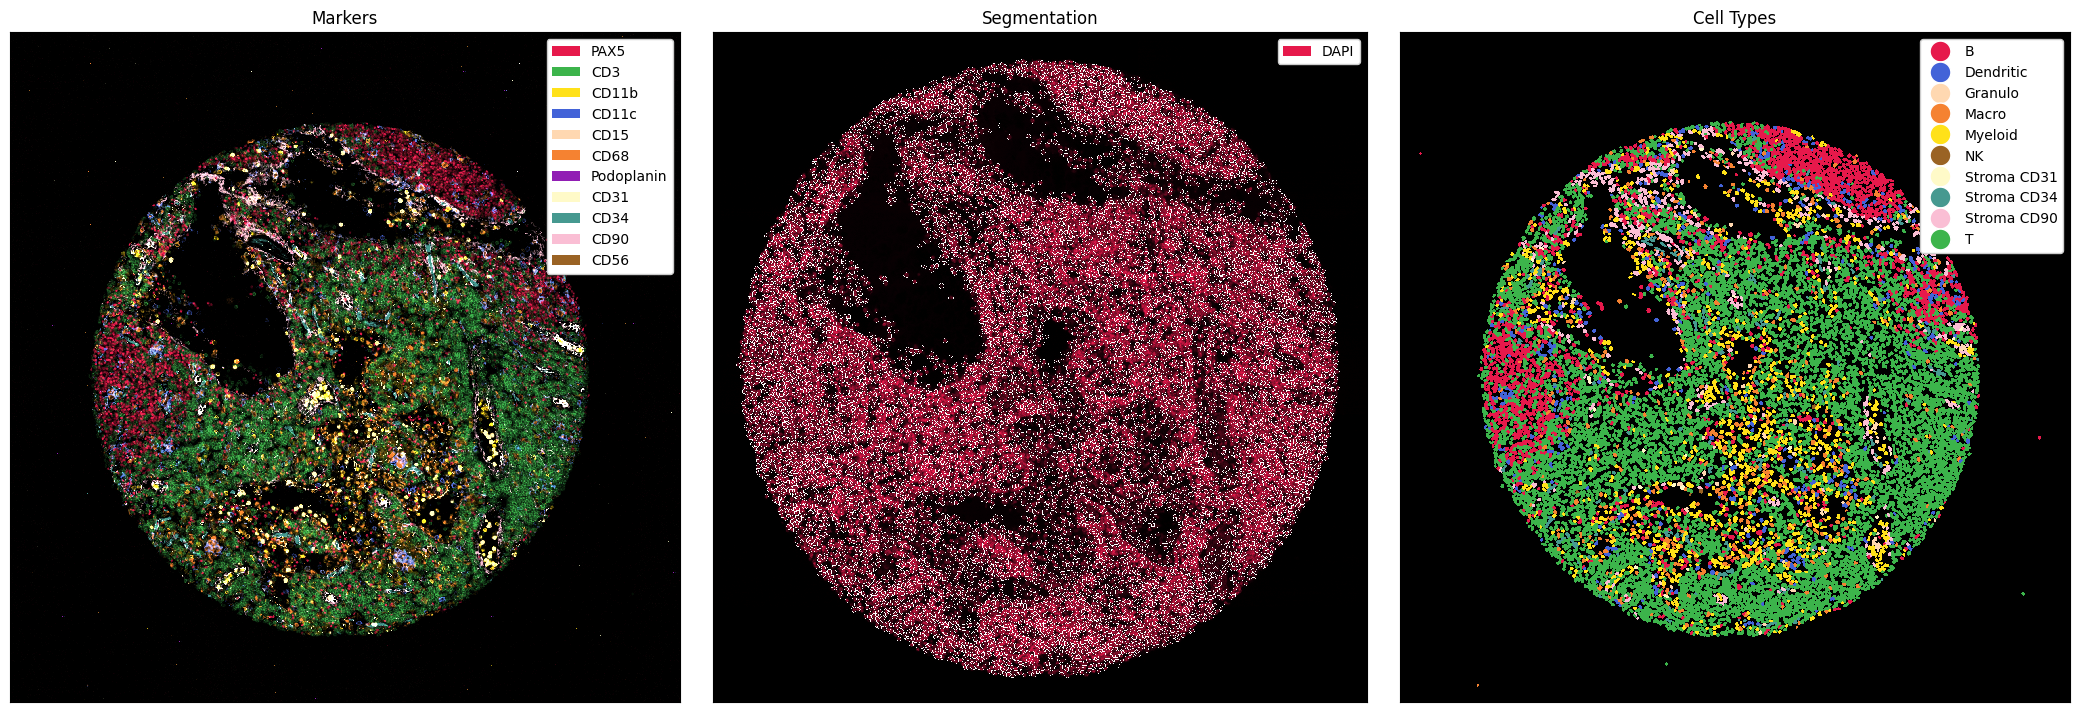

In [9]:
# this is how the image in the README was created
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
_ = ds_processed.pp[channels_celltypes].pl.colorize(colors).pl.autocrop(padding=100).pl.show(ax=ax[0])
_ = ds.pp['DAPI'].pl.autocrop(padding=100).pl.show(render_segmentation=True, ax=ax[1])
_ = ds_with_ct_predictions.pl.autocrop(padding=100).pl.show(render_image=False, render_labels=True, ax=ax[2])


# removing the x and y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

# setting titles
ax[0].set_title('Markers')
ax[1].set_title('Segmentation')
ax[2].set_title('Cell Types')

plt.tight_layout()

Getting observations from the xarray object is very easy. We can simply use the method `pp.get_layer_as_df()`, which can also parse our cell types into human-readable format automatically.

In [10]:
# getting the obs with get_layer_as_df() to get human readable cell type annotations in a pandas data frame
ds_with_ct_predictions.pp.get_layer_as_df('_obs', celltypes_to_str=True)

,_labels,centroid-0,centroid-1
1,T,613.329787,768.420213
2,Macro,769.098446,707.544041
3,T,774.528409,644.284091
4,T,775.902878,592.744604
5,Myeloid,668.844749,729.310502
...,...,...,...
12556,B,2340.362319,1846.492754
12557,Macro,2216.324138,2296.089655
12558,T,2265.910853,2231.992248
12559,B,2281.480687,2218.424893


## Cell Type Prediction with Astir

There also exist more involved methods of predicting cell types, such as astir. Here is a quick example on how one could apply astir to the previous image.

In [11]:
ds_processed

<xarray.Dataset>
Dimensions:         (labels: 8, la_props: 2, cells: 12560, features: 3,
                     y: 3000, x: 3000, channels: 16)
Coordinates:
  * cells           (cells) int64 1 2 3 4 5 6 ... 12556 12557 12558 12559 12560
  * channels        (channels) <U11 'PAX5' 'CD3' 'CD11b' ... 'CD45RA' 'CD45RO'
  * features        (features) <U10 '_labels' 'centroid-0' 'centroid-1'
  * la_props        (la_props) <U6 '_color' '_name'
  * labels          (labels) int64 1 2 3 4 5 6 7 8
  * x               (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * y               (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
Data variables:
    _la_properties  (labels, la_props) <U20 'C1' ... 'Vascular (CD31+CD34)'
    _obs            (cells, features) float64 7.0 613.3 ... 2.249e+03 2.237e+03
    _segmentation   (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    _image          (channels, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    _intensity      (cells, channels) float64 0.004255 2.46 ... 1.384 0.06662

In [12]:
# minor reformatting
seg = ds_processed['_segmentation'].values
ds_for_astir = ds_processed.pp.drop_layers('_obs').pp.drop_layers('_la_properties').pp.add_segmentation(seg)

In [13]:
ds_for_astir

<xarray.Dataset>
Dimensions:        (channels: 16, x: 3000, y: 3000, cells: 12560, features: 2)
Coordinates:
  * channels       (channels) <U11 'PAX5' 'CD3' 'CD11b' ... 'CD45RA' 'CD45RO'
  * x              (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * y              (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * cells          (cells) int64 1 2 3 4 5 6 ... 12556 12557 12558 12559 12560
  * features       (features) <U10 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    _intensity     (cells, channels) float64 0.004255 2.46 ... 1.384 0.06662
    _segmentation  (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    _obs           (cells, features) float64 613.3 768.4 ... 2.249e+03 2.237e+03

In [ ]:
# using astir to predict cell types
# note the slightly different structure of the marker dictionary
ct_marker_dict = {'cell_type': {'B': ['PAX5'], 'T': ['CD3'], 'Myeloid': ['CD11b'], 'Dendritic': ['CD11c'], 'Granulo': ['CD15'], 'Macro': ['CD68'], 'Stroma PDPN': ['Podoplanin'], 'Stroma CD31': ['CD31'], 'Stroma CD34': ['CD34'], 'Stroma CD90': ['CD90'], 'NK': ['CD56']}}
ds_with_ct_predictions_astir = ds_for_astir.tl.astir(ct_marker_dict)

The image is not of type uint8, which is required for astir to work properly. Use pp.convert_to_8bit() to convert the image to uint8. If you applied operations such as filtering, you may ignore this warning.
training restart 5/5:  40%|████      | 2/5 [ 3.47s/epochs, current loss: -1897.9]

In [ ]:
# adding custom colors and adding observations back in
cell_types = ['B', 'T', 'Myeloid', 'Dendritic', 'Granulo', 'Macro', 'Stroma PDPN', 'Stroma CD31', 'Stroma CD34', 'Stroma CD90', 'NK', 'Other']
ds_with_ct_predictions_astir = ds_with_ct_predictions_astir.la.set_label_colors(cell_types, colors + ['darkgray']).pp.add_observations()

In [ ]:
ds_with_ct_predictions_astir

In [ ]:
# plotting the astir and the argmax predictions
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
_ = ds_processed.pp[channels_celltypes].pl.colorize(colors).pl.autocrop(padding=100).pl.show(ax=ax[0])
_ = ds_with_ct_predictions_astir.pl.autocrop(padding=100).pl.show(render_image=False, render_labels=True, ax=ax[1])
_ = ds_with_ct_predictions.pl.autocrop(padding=100).pl.show(render_image=False, render_labels=True, ax=ax[2])

# removing the x and y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

# setting titles
ax[0].set_title('Markers')
ax[1].set_title('Astir Predictions')
ax[2].set_title('Argmax Predictions')

plt.tight_layout()

## Marker Binarization

For some (functional) markers, we want to binarize them (i. e. is a cell positive or negative for that marker). This is performed in several steps:
1. First, the image needs to be thresholded. We already did this at the beginning of the notebook using the `pp.threshold()` method.
2. Afterwards, we need to once again quantify the expression for each cell. While we have already seen how to do this using the mean expression, we can also use things such as the percentage of positive pixels (after thresholding).
3. Next, we actually perform the binarization using `la.threshold_labels()`. This way, we could for example consider a cell positive for CD4 only if more than 90% of its pixels have a non-zero intensity value.
4. Finally, we create a hierarchy of cell subtypes, which is based on the labels we computed previously and subsets them further by using the binarized functional markers.

In [ ]:
# adding a new quantification: the percentage of positive pixels (this requires appropriate thresholding, as we have performed ealier)
ds_with_ct_predictions = ds_with_ct_predictions.pp.add_quantification(func=sp.percentage_positive, key_added='_percentage_positive')

In [ ]:
# these thresholds are the percentages of positive cells required
# so a cell with more than 50% of non-zero CD4 pixels would be considered CD4 positive
threshold_dict = {
    "CD4": 0.5,
    "CD8": 0.5,
    "Ki-67": 0.5,
    "CD45RA": 0.5,
    "CD45RO": 0.5
}

ds_with_binarization = ds_with_ct_predictions.la.threshold_labels(threshold_dict, layer_key='_percentage_positive')

In [ ]:
# under the hood, we can see that our new object now contains binarization columns in the _obs field
ds_with_binarization.pp.get_layer_as_df().head()

## Cell Subtype Prediction

Finally, it is time to combine the broad cell type predictions with the binarization results in order to predict more fine-grained cell types. Here, we use a dictionary to define a cell type hierarchy, and then use the method `la.predict_cell_subtypes()` to subset our cell types accordingly.

In [ ]:
# calling of cell subtypes with a provided hierarchy
subtype_dict = {
    'B': {
        'subtypes': [
            {
                'name': 'B_prol',
                'markers': ['Ki-67']
            }
        ]
    },
    'T': {
        'subtypes': [
            {
                'name': 'T_h',
                'markers': ['CD4']
            },
            {
                'name': 'T_tox',
                'markers': ['CD8'],
                'subtypes': [
                    {
                        'name': 'T_tox_naive',
                        'markers': ['CD45RA']
                    },
                    {
                        'name': 'T_tox_mem',
                        'markers': ['CD45RO']
                    }
                ]
            }
        ]
    }
}

ds_with_subtypes = ds_with_binarization.la.predict_cell_subtypes(subtype_dict)

You can see that this added cell type labels on multiple levels to the `_obs` table, so you can always go back to a lower level. In addition, the most granular cell type labels have been added as the new default labels.

In [ ]:
ds_with_subtypes.pp.get_layer_as_df().head()

In [ ]:
# plotting the cell type predictions
plt.figure(figsize=(10, 10))
_ = ds_with_subtypes.pl.autocrop().pl.show(render_image=False, render_labels=True)

In [ ]:
# plotting the cell type predictions
plt.figure(figsize=(10, 10))
_ = (ds_with_subtypes.la[['T', 'T_h', 'T_tox', 'T_tox_mem', 'T_tox_naive']]
                     .la.set_label_colors(['T', 'T_h', 'T_tox', 'T_tox_mem', 'T_tox_naive'], 
                                          colors=['gray', 'orange', 'deepskyblue', 'darkblue', 'darkviolet'])
                     .pl.autocrop()
                     .pl.show(render_image=False, render_labels=True))